In [1]:
from metadrive import MetaDriveEnv
from metadrive.policy.idm_policy import IDMPolicy
from IPython.display import Image, clear_output

env = MetaDriveEnv(dict(traffic_mode="trigger", map="O"))
env.reset(seed=0)
try:
    for i in range(10):
        o,r,d,_,_ = env.step([0,-0.2] if i < 100 or i> 150 else [0, 0.2])
        env.render(mode="topdown", 
                   scaling=2, 
                   camera_position=(100, 0), 
                   screen_size=(500, 500),
                   screen_record=True,
                   window=False,
                   text={"episode_step": env.engine.episode_step,
                         "mode": "Trigger"})
    env.top_down_renderer.generate_gif()
finally:
    env.close()
    clear_output()



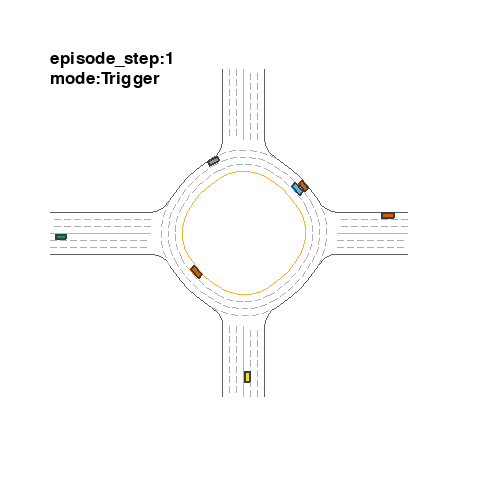

In [3]:
Image(open("demo.gif", "rb").read())

In [2]:

######### read simulation parameters from sim_conf.json #####
dt = params["sim_params"]["dt"]
control_horizon = params["sim_params"]["control_horizon"]
n = params["sim_params"]["state_dim"]
m = params["sim_params"]["control_dim"]

T_horizon = params["sim_params"]["time_horizon"]
S = int(T_horizon/dt)

M = params["prediction_params"]["num_predictions"]
prediction_cov = params["prediction_params"]["pred_cov"]

goal = params["optimization_params"]["goal"]
goal_lane = params["optimization_params"]["goal_lane"]
goal_heading = params["optimization_params"]["goal_heading"]

comf_weights = params["optimization_params"]["comfort_weights"]
control_weights = params["optimization_params"]["control_weights"]
running_weights = params["optimization_params"]["running_cost_weights"]

violation_weight = params["optimization_params"]["slack_weight"]
barrier_weight = params["optimization_params"]["barrier_weight"]

def kl_divergence(mu1, mu2, sigma1, sigma2):
  
    # Dimensionality of the Gaussians
    dim = mu1.shape[0]
    
    # Inverse and determinant of the second Gaussian's covariance
    sigma2_inv = np.linalg.inv(sigma2)
    det_sigma1 = np.linalg.det(sigma1)
    det_sigma2 = np.linalg.det(sigma2)
    
    # Terms in KLD
    term1 = np.trace(sigma2_inv @ sigma1)  # trace of Sigma_2^{-1} Sigma_1
    term2 = (mu2 - mu1).T @ sigma2_inv @ (mu2 - mu1)  # quadratic form
    term3 = np.log(det_sigma2 / det_sigma1)  # log determinant ratio
    
    # KLD formula
    kl_div = 0.5 * (term1 + term2 - dim + term3)
    
    return kl_div

def wasserstein_gaussian(mu1, mu2, sigma1, sigma2):
    ### formula for wasserstein dist = ||mu_x - mu_y||**2 + trace(sigma_x + sigma_y - 2 sqrt(sqrt(sigma_y)* sigma_x * sqrt(sigma_y)))
    
    mean_diff = np.linalg.norm(mu1 - mu2)

    sigma_1_sqrt = sqrtm(sigma1)

    cov_prod = sigma_1_sqrt @ sigma2 @ sigma_1_sqrt
    cov_prod_sqrt = sqrtm(cov_prod)

    wasserstein_dist = mean_diff**2 + np.trace(sigma1 + sigma1 - 2 * cov_prod_sqrt)

    return np.real(wasserstein_dist)  ### using np.real as near-singular matrices can cause imaginary values when we take sqrt of a matrix


def simple_gaussian_metric(mu1, mu2, sigma1, sigma2):
    ### formula for wasserstein dist = ||mu_x - mu_y||**2 + trace(sigma_x + sigma_y - 2 sqrt(sqrt(sigma_y)* sigma_x * sqrt(sigma_y)))
    
    mean_diff = np.linalg.norm(mu1 - mu2)

    sigma_diff = np.linalg.norm(sigma1 - sigma2) 

    return mean_diff*10 + sigma_diff

def risk(kl_div, beta, alpha):
    return beta + (np.exp(-alpha * kl_div))

def bicycle_dynamics_numpy(state,control,L):
    
    dx = state[3] * np.cos(state[2])
    dy = state[3] * np.sin(state[2])
    dtheta = state[3]/L * np.tan(control[1])
    dspeed = control[0]

    # print(dx,dy,dtheta,dspeed,dsteering)

    dstate = np.array([dx,dy,dtheta,dspeed])
    return dstate



def bicycle_dynamics(state,control,L):
    dx = state[3] * cs.cos(state[2])
    dy = state[3] * cs.sin(state[2])
    dtheta = state[3]/L * cs.tan(control[1])
    dspeed = control[0]

    return cs.vertcat(dx,dy,dtheta,dspeed)


def init_plan_states(vehicle):
    
    prediction = np.zeros((n,control_horizon))
    init_state = np.array([vehicle.position[0],vehicle.position[1],np.arctan2(vehicle.heading[1],vehicle.heading[0]),3])
    
    prediction[:,0] = init_state
    control_plan = np.zeros((2,control_horizon))
    
    for k in range(1,control_horizon):
        # control = np.array([vehicle.throttle_brake + np.random.randn()*0.001,np.random.randn()*0.01*vehicle.STEERING_INCREMENT])
        control_plan[:,k] = np.array([0.005,0])
        prediction[:,k] = prediction[:,k-1] + dt * bicycle_dynamics_numpy(prediction[:,k-1],control_plan[:,k],vehicle.LENGTH)

    return prediction,control_plan



def predict_states(vehicle): ###### CONSTANT ACCELERATION AND STEERING 
    
    prediction = np.zeros((n,control_horizon))
    init_state = np.array([vehicle.position[0],vehicle.position[1],np.arctan2(vehicle.heading[1],vehicle.heading[0]),vehicle.speed])
    
    prediction[:,0] = init_state

    for k in range(1,control_horizon):
        # control = np.array([vehicle.throttle_brake + np.random.randn()*0.001,np.random.randn()*0.01*vehicle.STEERING_INCREMENT])
        control = np.array([np.random.randn() * prediction_cov,vehicle.steering + np.random.randn() * prediction_cov])
        prediction[:,k] = prediction[:,k-1] + dt * bicycle_dynamics_numpy(prediction[:,k-1],control,vehicle.LENGTH)

    return prediction


def predict_states_CV(vehicle): ####### CONSTANT VELOCITY ##########
    
    prediction = np.zeros((n,control_horizon))
    init_state = np.array([vehicle.position[0],vehicle.position[1],np.arctan2(vehicle.heading[1],vehicle.heading[0]),vehicle.speed])

    prediction[:,0] = init_state

    prediction[2,:] = np.arctan2(vehicle.heading[1],vehicle.heading[0]) + np.random.randn(control_horizon) * 1e-3

    prediction[3,:] = vehicle.speed + np.random.randn(control_horizon) * 1e-3
    
    for k in range(1,control_horizon):
        velx = np.cos(prediction[2,k]) * prediction[3,k] 
        vely = np.sin(prediction[2,k]) * prediction[3,k]

        prediction[0,k] = prediction[0,k-1] + dt * velx
        prediction[1,k] = prediction[1,k-1] + dt * vely

    return prediction


def control(vehicles,state_plan,control_plan,time_instance):
    # print(vehicle.speed_km_h, vehicle.max_speed_km_h)
    # print(vehicle.position)
    # print(vehicle.navigation.current_road)

    ego = vehicles[0]

    # if len(vehicles) > 1:
    #     other_vehs = []
    #     for j in range(1,len(vehicles)):
    #         other_vehs.append(vehicles[j])
    
    
    
    init_x = ego.position[0]
    init_y = ego.position[1]
    init_heading = np.arctan2(ego.heading[1],ego.heading[0])
    init_speed = ego.speed
    
    init_state =  cs.vertcat(init_x,init_y, init_heading, init_speed)

    current_road = ego.navigation.current_road
    
    current_lane = ego.lane
    
    opti = cs.Opti()
    
    L = ego.LENGTH # Wheelbase
    
    # # Create an opti instance
    
    # # Define state variables over the horizon (x, y, theta, v, delta)
    X = opti.variable(n, control_horizon)  # State trajectory: [x, y, theta, v, delta]
    x = X[0, :]  # x position
    y = X[1, :]  # y position
    theta = X[2, :]  # heading angle
    v = X[3, :]  # velocity
    
    # # Define control variables over the horizon (acceleration and steering rate)
    U = opti.variable(2, control_horizon)  # Control trajectory: [a, delta_rate]
    a = U[0, :]  # acceleration
    delta = U[1, :]  # steering rate
        
    # # Dynamics of the bicycle model (discrete-time using Euler integration)

    for k in range(1,control_horizon):
        
        dstate = bicycle_dynamics(X[:,k-1],U[:,k-1],L)

        #### euler integration #####
        x_next = X[:,k-1] + dt * dstate

        #### rk4 integration ####
        # k1 = bicycle_dynamics(X[:,k-1],U[:,k-1],L)
        # k2 = bicycle_dynamics(X[:,k-1] + dt/2 * k1,U[:,k-1],L)
        # k3 = bicycle_dynamics(X[:,k-1] + dt/2 * k2,U[:,k-1],L)
        # k4 = bicycle_dynamics(X[:,k-1] + dt * k3,U[:,k-1],L)

        # x_next = X[:,k-1] + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
        

        #     # Apply dynamics constraints
        opti.subject_to(X[:, k] == x_next)

    violation_cost = 0
    barrier_cost = 0

    ######## collision-avoidance constraints ######
    
    if len(vehicles) > 1:
        
        N = len(vehicles) -1  #### discount ego vehicle ###
        
        constraint_slack_all = opti.variable(M*N, control_horizon)               

        for j in range(N):
            ov = vehicles[j+1]

            ov_preds = np.zeros((M,n,control_horizon))

            confidence = np.random.uniform(0,1,M)

            confidence = confidence/np.sum(confidence)
            
            for m in range(M):

                ov_path = predict_states_CV(ov)

                # ov_path = predict_states(ov)
                # ov_path = predict_states_GLK(ov)
                
                ov_preds[m,:,:] = ov_path


                for k in range(control_horizon):
                    # dx = (X[0,k] - ov_path[0,k])**2 * 10/(k+1)
                    # dy = (X[1,k] - ov_path[1,k])**2 * 10/(k+1)

                    s_t = X[:2,k] - ov_path[:2,k]

                    m1 = np.array([state_plan[0,k],state_plan[1,k]])
                    m2 = np.array([ov_path[0,k],ov_path[1,k]])

                    C1 = (k+1) * np.diag([1,1]) * 1e-3
                    C2 = (k+1) * np.diag([1,1]) * 1e-1
                    
                    # risk_metric = kl_divergence(m1,m2,C1,C2)
                    risk_metric = wasserstein_gaussian(m1,m2,C1,C2)
                    # risk_metric = simple_gaussian_metric(m1,m2,C1,C2)
                    
                    dist = s_t.T @ np.linalg.inv(C2) @ s_t
                    # l2dist = s_t.T @ s_t

                    ##### soft_constraint #####
                    # violation_cost += (dist - L**2 * risk(risk_metric,confidence[m],1e-5))**2 * 1e3  # violation_weight

                    ############ uncomment for constraint!!! ##############
                    
                    # opti.subject_to(dist >= 1 * L**2 * risk(risk_metric,confidence[m],1e-5) + constraint_slack[m,k])                            
                    # violation_cost += constraint_slack[m,k]**2 * violation_weight + barrier_cost * barrier_weight
    
                    # opti.subject_to(constraint_slack[m,k]>= - L**2)

                    #### L2 distance constraint ######
                    #dist = cs.sqrt(dx + dy)
                    # opti.subject_to( dist>= 1.3*L + L * np.exp(-1e-4 * kld) + constraint_slack[m,k])                            
                    
                    # opti.subject_to(constraint_slack[m,k]>= -0.6*L)

                    ##### Barrier penalty ##### 
                    # barrier_cost = cs.log(1 + cs.exp( -confidence[m] * 0.2* (dist - L**2 * risk(risk_metric,confidence[m],1e-5)+ 1e-4 )))
                    # barrier_cost = 0
                    
                    barrier_cost = np.log(1 + cs.exp( -confidence[m] * 5e0 * (dist - L**2 * risk(risk_metric,confidence[m],1e-2))))
                    violation_cost += barrier_cost * barrier_weight
                

      
                
    # # Initial state constraint
    opti.subject_to(X[:, 0] == init_state)
    
    # # Control bounds
    opti.subject_to(opti.bounded(-1.001, a, 1.001))  # Acceleration limits
    opti.subject_to(opti.bounded(-0.8, delta, 0.8))  # Steering rate limits
    # opti.subject_to(opti.bounded(-0.01, v, ego.max_speed_km_h))
    # opti.subject_to(opti.bounded(-4.,y,9.5))
    # opti.subject_to(y<=9)
    
    # # Cost function (example: penalize distance to target and control effort)

    cost = 0
    running_cost = 0
    comfort_cost = 0
    
    goals = np.array([0.0, goal_lane, goal_heading, 0.0])
    
    for k in range(control_horizon):
        # if k<=10:
            # running_cost += cs.sumsqr(X[1, k] - goal_lane) * 1e1    #*time_instance * dt
            # running_cost += cs.sumsqr(X[2, k] - goal_heading) * 1e3  #* time_instance * dt      
            # cost += cs.sumsqr(X[:3,k] - goal) * 1e4
             

        x_g = X[:,k] - goals
        running_cost += x_g.T @ np.diag(running_weights) @ x_g
            
        running_cost += U[:,k].T @ np.diag([control_weights]) @ U[:,k] # Penalize control effort (acceleration and steering rate)
        running_cost -= X[0,k] * 1e2 / np.abs(init_x)

        if k > 0:
            dstate = X[:,k] - X[:,k-1]
            comfort_cost += dstate.T @ np.diag(comf_weights) @ dstate
        
    # # Terminal cost (encourage ending close to the target)
    # cost += cs.sumsqr(X[1, -1] - goal_lane) * 1e2
    
    cost += (running_cost + violation_cost + comfort_cost)/control_horizon

    #### set initial guess
    opti.set_initial(X[:,0:-1], state_plan[:,1:])
    opti.set_initial(U[:,0:-1], control_plan[:,1:])

    # # Set the cost function
    opti.minimize(cost)
    
    # # Solver options
    opti.solver('ipopt', {
        'ipopt.print_level': 0,  # Suppresses the print level of IPOPT
        'print_time': False,     # Disables the printing of solver timing information
        'ipopt.sb': 'yes',       # Suppresses the IPOPT banner
        'ipopt.max_iter':5000,                
        'ipopt.acceptable_tol':1e-1,
        'ipopt.acceptable_iter':20,
        'ipopt.bound_relax_factor':1e-4,
        'ipopt.bound_push':1e-2,
    })
    
    
    # # Solve the optimization problem
    sol = opti.solve()

    # print(sol.value(cost))
    
    # # Extract the optimal trajectory
    x_opt = sol.value(X)
    u_opt = sol.value(U)

    acc = u_opt[0,1]
    
    steering = u_opt[1,1]
    
    state_plan = x_opt
    control_plan = u_opt
        
    return [steering, acc, state_plan, control_plan]



In [3]:

rendering = False  ####### Set to TRUE if you want to 3d render from metadrive's main camera, FALSE if you want only top-view

# env=MetaDriveEnv(dict(map="S",
#                       log_level=50,
#                       traffic_density=0.5,
#                       random_traffic = False,
#                      use_render = rendering,
#                      agent_policy = IDMPolicy))

env=MetaDriveEnv(dict(map="S",
                      log_level=50,
                      traffic_density=0.5,
                     use_render = rendering,
                      random_traffic =False,  #### randomize spawn points 
                     use_AI_protector = False,
                     drivable_area_extension = False))



env.reset()

comp_time_array = []
reward_array = []

try:
    frames = []
    movie3d = []
    # run several episodes

    #### initialize a plan for ego, static plan ####
    
    ego = env.engine.traffic_manager.vehicles[0]
    state_plan,control_plan = init_plan_states(ego)


    cfg=env.config["vehicle_config"]
    cfg["navigation"]=None    
    
    total_reward = 0
    
    for step in range(S):

        vehicles = env.engine.traffic_manager.vehicles
        
        ego = vehicles[0]
        # print(ego.lane,ego.lane.position,ego.lane.heading)
        # print(ego.lane.local_coordinates(ego.position))
        
        tic = time.time()
        
        steer,acc,state_plan,control_plan  = control(vehicles,state_plan,control_plan,step)
        
        toc = time.time()

        comp_time_array.append(toc - tic) 
        
        o,r,term,trunc,info = env.step([steer,acc])
        
        reward_array.append(r)

        ######## TOP DOWN RENDER #########

        frame = env.render(mode="topdown", 
                           window=False,
                           screen_size=(400, 400))
        frames.append(frame)

        
        ####### 3D render ###########

        if rendering == True:
                        
            img_interface = env.main_camera.perceive()
            movie3d.append(img_interface[..., ::-1])  #### convert BGR to RGB

finally:
    print('avg computation time = ' + str(sum(comp_time_array)/step))
    print('total reward = ' + str(sum(reward_array)))
    env.close()

avg computation time = 642.7535583972931
total reward = 0.007866496803707693


KeyboardInterrupt: 

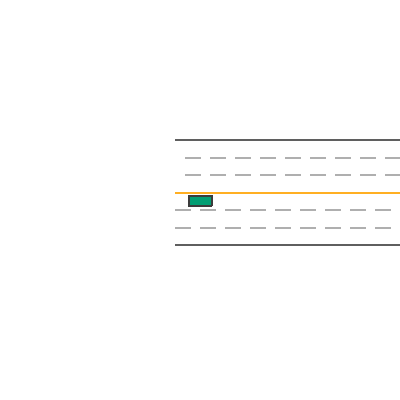

In [9]:
#### use the following lines to generate a GIF from sequences of images####

generate_gif(frames,"./videos/idmpolicy.gif",duration = 50)
Image(open("./videos/idmpolicy.gif", 'rb').read())

# if rendering == True:
    
#     import mediapy
#     import subprocess
    
#     for i in range(len(movie3d)):
#         img = './metadrive_video/img' + str(i) + '.png'
#         mediapy.write_image(img, movie3d[i])
 
#         ### !!!! use following command in ffmpeg to generate a gif from sequence of imgs
#         ### ffmpeg -framerate 10 -i img%d.png -vf "scale=640:-1:flags=lanczos" output.gif 
#     name = 'kld_risk_render_intersection_safe_json'
#     framerate = str(10)
#     command = ['ffmpeg','-framerate',framerate,'-i','./metadrive_video/img%d.png','-vf','scale=640:-1:flags=lanczos', './metadrive_video/'+name+'.gif']
#     subprocess.run(command)

In [8]:
from metadrive.component.vehicle.base_vehicle import BaseVehicle
from metadrive.utils import print_source
# print_source(BaseVehicle._set_action)
# print_source(BaseVehicle._apply_throttle_brake)

from metadrive.envs.metadrive_env import MetaDriveEnv
from metadrive.component.vehicle.vehicle_type import DefaultVehicle
from metadrive.utils import generate_gif

env=MetaDriveEnv(dict(map="S", traffic_density=0))
frames = []
try:
    env.reset()
    cfg=env.config["vehicle_config"]
    cfg["navigation"]=None # it doesn't need navigation system
    v = env.engine.spawn_object(DefaultVehicle, 
                                vehicle_config=cfg, 
                                position=[30,0], 
                                heading=0)
    for _ in range(100):
        v.before_step([0, 0.5])
        o, _,_,_,info = env.step([0,2])
        frame=env.render(mode="topdown", 
                         window=False,
                         screen_size=(800, 200),
                         camera_position=(60, 7))
        frames.append(frame)
    generate_gif(frames, gif_name="demo.gif")
finally:
    env.close()

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


KeyboardInterrupt: 

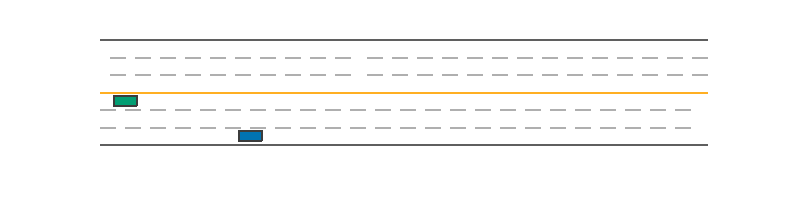

In [7]:
from IPython.display import Image
Image(open("demo.gif", "rb").read())

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[WARNING] Panda Rendering is off now, can not render. Please set config['use_render'] = True! (base_env.py:503)
NoneType: None
[WARNING] env.vehicle will be deprecated soon. Use env.agent instead (base_env.py:731)
[WARNING] Panda Rendering is off now, can not render. Please set config['use_render'] = True! (base_env.py:503)
NoneType: None
[WARNING] Panda Rendering is off now, can not render. Please set config['use_render'] = True! (base_env.py:503)
NoneType: None
[WARNING] Panda Rendering is off now, can not render. Please set config['use_render'] = True! (base_env.py:503)
NoneType: None
[WARNING] Panda Rendering is off now, can not ren

Reached all waypoints!


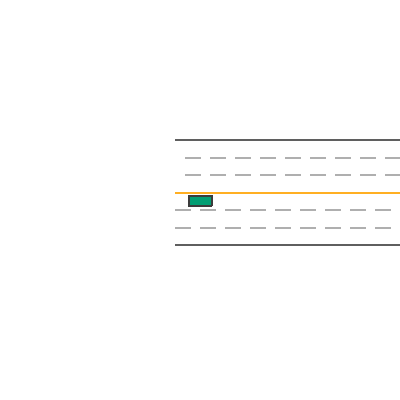

In [3]:
# File: pid_waypoint_follower.py
from metadrive.utils import generate_gif
import numpy as np
from metadrive import MetaDriveEnv

class PIDController:
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.prev_error = 0
        self.integral = 0

    def compute_control(self, target, current):
        # Calculate error
        error = target - current
        # Proportional term
        proportional = self.kp * error
        # Integral term
        self.integral += error
        integral = self.ki * self.integral
        # Derivative term
        derivative = self.kd * (error - self.prev_error)
        # Save error for next iteration
        self.prev_error = error
        # Return control output
        return proportional + integral + derivative


def calculate_target_angle(vehicle_position, waypoints):
    """
    Calculate the desired angle to the next waypoint.
    """
    closest_waypoint = waypoints[0]
    target_vector = np.array(closest_waypoint) - np.array(vehicle_position)[:2]
    desired_angle = np.arctan2(target_vector[1], target_vector[0])
    return desired_angle


def main():
    # Initialize MetaDrive environment
    env = MetaDriveEnv(dict(map = "S", start_seed=0, use_render = False))
    env.reset()
    
    # Define waypoints (sample)
    waypoints = [
        (20, 3.5), (40, 7), (60, 3.5), (80, 7)  # Example waypoints in (x, y)
    ]
    
    # PID controller for steering and throttle
    pid_steering = PIDController(kp=1.0, ki=0.0, kd=0.1)
    pid_throttle = PIDController(kp=1.0, ki=0.1, kd=0.05)
    frames =[]
    try:
        for step in range(1000):  # Simulate for 1000 steps
            env.render()

            # Get current vehicle state
            obs = env.vehicle.get_state()
            vehicle_position = obs["position"]  # (x, y, z) position of the vehicle
            vehicle_heading = obs["heading_theta"]  # Current heading in radians
            
            # Remove waypoints already passed
            if np.linalg.norm(np.array(waypoints[0]) - np.array(vehicle_position)[:2]) < 2:
                waypoints.pop(0)
                if not waypoints:
                    print("Reached all waypoints!")
                    break
            
            # Calculate control inputs
            target_angle = calculate_target_angle(vehicle_position, waypoints)
            steering_error = target_angle - vehicle_heading
            steering_action = pid_steering.compute_control(steering_error, 0)
            
            # Set throttle (speed control to maintain constant speed)
            target_speed = 10  # Target speed in m/s
            current_speed = np.linalg.norm(obs["velocity"])  # Current speed in m/s
            throttle_action = pid_throttle.compute_control(target_speed, current_speed)
            
            # Control the vehicle
            env.step([steering_action, throttle_action])
            ######## TOP DOWN RENDER #########

            frame = env.render(mode="topdown", 
                            window=False,
                            screen_size=(400, 400))
            frames.append(frame)

        generate_gif(frames, gif_name="demo.gif")
    finally:
        env.close()
        
main()

from IPython.display import Image
Image(open("demo.gif", "rb").read())



In [37]:
import numpy as np
x = np.random.rand(4,1,3)
y = np.random.rand(1,4,3)
z = x-y
w = np.random.rand(4,3)


In [38]:
n = np.argmin(z,axis=1)
w[n[1]]

array([[0.0750963 , 0.9209596 , 0.67243703],
       [0.0698399 , 0.51207307, 0.75071985],
       [0.9962147 , 0.41235034, 0.19506033]])

In [43]:
def IDM_one_step(x,ego_x,dt):
    '''
    ego_x (Nsample,4)
    x (Nveh, Nsample, 4)
    return (Nveh, Nsample, 4)
    '''
    s_0 = 8 #minimum safe distance for IDM
    a_max = 1.5 # maximum acceleration for IDM
    b = 1 #comfortable deceleration for IDM
    delta = 4 #-- acceleration exponent for IDM (typically 4)
    
    T=0.5
    v_des = 3#-- desired speed for each vehicle
    Nveh = x.shape[0]
    # v_des = np.random.uniform(0.5,2,(x.shape[0]+1,))
    # T = np.random.uniform(0.5,2,(x.shape[0]+1,)) #1.8 # desired time headway for IDM
    
    ego_x = ego_x[np.newaxis,:] # (1, Nsample, 4)
    x = np.append(ego_x,x, axis = 0) #(Nveh+1, Nsample,4)
    x_pos, y_pos, psi, v = x[:, :, 0], x[:,:, 1], x[:,:, 2], x[:,:, 3] # (Nveh+1,Nsample) each

    # Compute pairwise distances between vehicles
    x_diff = x_pos[:, np.newaxis] - x_pos[np.newaxis] #(Nveh+1,1,Nsample)-(1,Nveh+1,Nsample) = (Nveh+1,Nveh+1,Nsample)
    y_diff = y_pos[:, np.newaxis] - y_pos[np.newaxis]
    distances = np.sqrt(x_diff**2 + y_diff**2)

    # Mask for vehicles that are in front and in the near lane
    front_mask = (x_diff < 0) & (np.abs(y_diff) <= 2) # 1m is the threshold to consider as near lane

    # Set distance to infinity where vehicles are not in front or not in the same lane
    distances = np.where(front_mask, distances, np.inf)

    # Find the nearest lead vehicle for each vehicle
    min_distances = np.min(distances, axis=1) # (Nveh+1,Nsample)
    lead_vehicle_indices = np.argmin(distances, axis=1) 
    indices = np.arange(v.shape[1])  # Sample indices (0 to Nsample-1)
    v_lead = v[lead_vehicle_indices, indices]  # Extract lead vehicle velocities
    # Get the velocities of the lead vehicles
    # v_lead = v[lead_vehicle_indices]
    # v_des = v_des[lead_vehicle_indices]
    # T = T[lead_vehicle_indices]
    # Calculate desired gap for IDM
    s_star = s_0 + v * T + (v * (v - v_lead)) / (2 * np.sqrt(a_max * b))

    # IDM acceleration calculation for each vehicle
    a_idm = a_max * (1 - (v / v_des)**delta - (s_star / min_distances)**2)
    a_idm = np.where(min_distances == np.inf, a_max * (1 - (v / v_des)**delta), a_idm)  # If no lead, accelerate to v_des

    # Update each vehicle's state based on IDM dynamics
    x_pos += v * dt * np.cos(psi)
    y_pos += v * dt * np.sin(psi)
    v = np.maximum(0, v + a_idm * dt)  # Ensure velocity doesn't go negative

    # Combine the updated values back into a state matrix
    X_updated = np.stack([x_pos, y_pos, psi, v], axis=-1)
    return X_updated[1:] # exclude ego

In [45]:
# Sample input data
Nveh = 5  # Number of vehicles
Nsample = 10  # Number of samples
dt = 0.1  # Time step

# Random initial positions, angles, and velocities for vehicles
np.random.seed(42)  # For reproducibility
x = np.random.rand(Nveh, Nsample, 4)  # (Nveh, Nsample, 4)
ego_x = np.array([[0.0, 0.0, 0.0, 2.0] for _ in range(Nsample)])  # Ego vehicle state (Nsample, 4)

# Run IDM_one_step
updated_states = IDM_one_step(x, ego_x, dt)

# Print the results
print("Updated States (Nveh, Nsample, 4):")
print(updated_states.shape)

Updated States (Nveh, Nsample, 4):
(5, 10, 4)


In [171]:
import pickle
import numpy as np
import os

directory = './data/X-IDM-Merge/'

# Initialize lists to store data with an extra dimension
info = []
inputs = []
min_dists = []
loaded_data4 = []

# Iterate over all files in the directory
for i, filename in enumerate(os.listdir(directory)):
    if filename.endswith('.pkl'):  # Only process pickle files
        filepath = os.path.join(directory, filename)
        with open(filepath, 'rb') as f:
            data1 = pickle.load(f)
            data2 = pickle.load(f)
            data3 = pickle.load(f)
            data4 = pickle.load(f)
        
        # Add an extra dimension for the file index
        info.append(np.expand_dims(data1, axis=0))  # Add dimension at axis 0
        inputs.append(np.expand_dims(data2, axis=0))
        min_dists.append(np.expand_dims(data3, axis=0))
        loaded_data4.append(np.expand_dims(data4, axis=0))
        
        # print(f"----------{i}th file---------")
        # print(np.array(data1).shape)
# Concatenate data along the new dimension
info = np.concatenate(info, axis=0)
inputs = np.concatenate(inputs, axis=0)
j_sr = inputs[:,1:] - inputs[:,:-1]
min_dists = np.concatenate(min_dists, axis=0)
loaded_data4 = np.concatenate(loaded_data4, axis=0)

# print(f"Data1 shape: {info}")
print(f"Data2 shape: {np.array(inputs).shape}")
# print(f"Data3 shape: {loaded_data3}")
# print(f"Data4 shape: {loaded_data4}")


Data2 shape: (20, 100, 2)


In [172]:
print(np.mean(inputs,axis=(0,1))*1e3)
print(np.mean(j_sr,axis=(0,1))*1e3)
print(np.mean(np.clip(np.min(min_dists,axis=1),0,None)))

[21.3    6.324]
[-1.21212121 -1.48484848]
0.43155794460722585


In [173]:
collision_count = 0
success_count = 0
dists = []
for j in range(info.shape[0]):
    for i in range(info.shape[1]):
        if info[j,i]["crash_vehicle"]:
            collision_count += 1
            break
        else:
            dists.append(min_dists[j,i])
            if abs(info[j,i]["xy"][1]-3.5) <= 0.5:
                success_count += 1
                break

print(collision_count)
print(success_count)


0
14


In [158]:
info.shape

(20, 100)